## Optimisation du modèle d'un point de vue métier

On a trouve que Light Gradient Boosting Machine sur le donnees desquilibrees est le modele le plus presis

- **True Positive (TP)**: Targets that are actually true and we have predicted them true (The loan is (correctly) refused: the   bank neither wins nor loses money)

- **True Negative (TN)**:  Targets which are actually false and we have predicted them false (The loan is reimbursed: the bank makes money)

- **False Positive (FP)**:  Targets which are actually false but we have predicted them true (The loan is refused by mistake: the bank loses money it could have made, but does not actually lose any money (Type-I Error))

- **False Negative (FN)**:  Targets which are actually tru but we have predicted them false (The loan is granted but the customer defaults: the bank loses money (Type-II Error))

**La problématique 'métier'**  - on doit prendre en compte qu'un **FP** (bon client considéré comme mauvais => crédit non accordé, donc manque à gagner du capital pour la banque) n'a pas le même coût qu'un **FN** (mauvais client à qui on accorde un prêt, donc perte sur le capital non remboursé). Un faux négatif est en effet 10 fois plus coûteux qu'un faux positif.



On va définir une fonction métier adaptée au projet qui permet d'attribuer plus de poids à la minimisation des **FN**.

Ainsi on va à nouveau effectuer une nouvelle optimisation des hyperparamètres via **HyperOpt** basant sur la fonction métier proposée (*Hyperopt is a Python library for serial and parallel optimization over awkward search spaces, which may include real-valued, discrete, and conditional dimensions*).

Les hyperparamètres seront choisis de manière à minimiser la perte d'argent pour la banque

In [2]:
#! pip install hyperopt

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import gc
import time, pickle
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, fbeta_score, f1_score, precision_score, recall_score 
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score

from sklearn.feature_selection import RFECV
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

from joblib import load, dump

import shap

import os

In [2]:
# Training data
app_train = pd.read_csv('app_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 242)


,Unnamed: 0,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM
0,0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,1,0,1,0,1,False
1,1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0,0,1,0,0,False
2,2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0,0,0,0,0,False
3,3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0,0,0,0,0,False
4,4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0,0,0,0,0,False


In [3]:
app_train = app_train.drop('Unnamed: 0', axis=1)
app_train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0,0,0,0,1,0,1,0,1,False
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0,0,0,0,0,0,1,0,0,False
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0,0,0,0,0,0,0,0,0,False
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0,0,0,0,0,0,0,0,0,False
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0,0,0,0,0,0,0,0,0,False


### Séparation des données

In [4]:
# Target sont les valeurs que nous voulons prédire
Target = np.array(app_train['TARGET'])

In [5]:
# Eliminer TARGET de app_train
data_to_model = app_train.drop(['TARGET', 'SK_ID_CURR'], axis = 1)

In [6]:
# Enregistrement des noms de colonnes pour une utilisation ultérieure
data_to_model_list = list(data_to_model.columns)

In [7]:
# Convertir en numpy array
data_to_model = np.array(data_to_model)

In [8]:
# Split the data into training and testing sets
train_data_to_model, test_data_to_model, train_Target, test_Target = train_test_split(data_to_model, Target, test_size = 0.25, random_state = 42)

In [9]:
print('Training data_to_model Shape:', train_data_to_model.shape)
print('Training Target Shape:', train_Target.shape)
print('Testing data_to_model Shape:', test_data_to_model.shape)
print('Testing Target Shape:', test_Target.shape)

Training data_to_model Shape: (230633, 239)
Training Target Shape: (230633,)
Testing data_to_model Shape: (76878, 239)
Testing Target Shape: (76878,)


### Prétraitement

In [10]:
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import MinMaxScaler

In [11]:
# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Fit on the training data
imputer.fit(train_data_to_model)

# Transform data
train_data_to_model = imputer.transform(train_data_to_model)
test_data_to_model = imputer.transform(test_data_to_model)

In [12]:
# Scale each feature to 0---1
scaler = MinMaxScaler(feature_range = (0, 1))

# Repeat with the scaler
scaler.fit(train_data_to_model)

train_data_to_model = scaler.transform(train_data_to_model)
test_data_to_model = scaler.transform(test_data_to_model)

One is going to creat a new function to minimize the risk for the
        loaning firm.
    
        Parameters
        --------
        - y_true : initial data
                   The true values of the target
        - y_pred : predicted data
                   The predicted values for the target
            
        Returns
        --------
        - score : float
                  The score for the prediction
    

In [13]:
def gain_score(y_true, y_pred) :
    
    (TN, FP, FN, TP) = confusion_matrix(y_true, y_pred).ravel()
    N = TN + FP    # total negatives cases
    P = TP + FN    # total positives cases
    
    #FN weight = -10   # The loan is granted but the customer defaults : the bank loses money
    #TN weight = 1     # The loan is reimbursed : the bank makes money
    #TP weight = 0     # The loan is (rightly) refused : the bank neither wins nor loses money
    #FP weight = -1    # Loan is refused by mistake : the bank loses money it could have made, 
                     
    # calculate total gains
    gain = TP*0 + TN*1 + FP*(-1) + FN*(-10)
    
    # best score : all observations are correctly predicted
    best_case = N*1 + P*0 

    # baseline : all observations are predicted = 0 (all the clients are predicted to be able to repay the loan)
    baseline = N*1 + P*(-10) 
    
    # normalize to get score between 0 (baseline) and 1
    score = (gain - baseline) / (best_case - baseline)
    
    return score

In [20]:
#Parameter space for HyperOptm 
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 600, 100),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
    'max_depth': hp.quniform('max_depth', 3, 7, 1),
    'subsample': hp.uniform('subsample', 0.60, 0.95),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
    'reg_lambda': hp.uniform('reg_lambda', 1, 20)
}

In [21]:
#One will create the objective function for the minimization 
#HyperOpt will seek to minimize the loss returned by this function
def objective(params, eval_metric = 'gain_score'):
    
    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda']
        }
  
    
    model= LGBMClassifier(**params)
    cv = StratifiedKFold(5)
 
    y_pred = cross_val_predict(model, train_data_to_model, train_Target, method='predict', cv=cv)
    score = gain_score(train_Target, y_pred)
  
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [22]:
# minimize the objective over the space of parameters
best = fmin(fn=objective, space=space, max_evals=10, algo=tpe.suggest)

100%|████████████████████████████████████████████████| 10/10 [06:21<00:00, 38.18s/trial, best loss: 0.9885156166147901]


In [15]:
print (best)

{'colsample_bytree': 0.6806278102760615, 'learning_rate': 0.018012483163512664, 'max_depth': 7.0, 'n_estimators': 600.0, 'reg_lambda': 15.96242469678541, 'subsample': 0.7058506837804701}


In [14]:
lgbm = LGBMClassifier(colsample_bytree = 0.9352366631038328, learning_rate = 0.019872833637311824, max_depth = 7, n_estimators = 500, reg_lambda = 18.286762029695563, subsample = 0.8468366692877104)

lgbm.fit(train_data_to_model, train_Target)

LGBMClassifier(colsample_bytree=0.9352366631038328,
               learning_rate=0.019872833637311824, max_depth=7,
               n_estimators=500, reg_lambda=18.286762029695563,
               subsample=0.8468366692877104)

In [15]:
roc_auc = roc_auc_score(test_Target, lgbm.predict_proba(test_data_to_model)[:,1])

In [16]:
roc_auc

0.759383067649265

In [17]:
Y_pred_proba = lgbm.predict_proba(test_data_to_model)

In [18]:
Y_pred = lgbm.predict(test_data_to_model)

In [19]:
def cutoff_pr(recall, precision, thresholds):
    """
    get cutoff point
    :param recall:
    :param precision:
    :param thresholds:
    :return:
    """
    f1_scores = 2 * (precision * recall) / (precision + recall)
    f1_ordered = sorted(zip(f1_scores, thresholds))
    return f1_ordered[-1][1]

Precision = TP / (TP + FP)

Recall = TP / (TP + FN)

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, \
    roc_curve, roc_auc_score, precision_recall_curve, auc

Precision, Recall, thresholds = precision_recall_curve(test_Target, Y_pred_proba[:, 1])
auc_pr = auc(Recall, Precision)
best_threshold_pr = cutoff_pr(Precision, Recall, thresholds)

In [21]:
best_threshold_pr

0.13743977444891342

In [22]:
thresholds

array([0.00387724, 0.00432396, 0.00530886, ..., 0.65068622, 0.67231058,
       0.6800552 ])

In [23]:
def get_pr_fn (thresh, y_test, y_pred):
    func_metier_list = []
    for i in thresh:
        print(i)
        y_pred_i = (y_pred[:, 1] > i).astype(int)
        matrix_conf = confusion_matrix(y_test, y_pred_i)
        fp, fn = matrix_conf[0, 1], matrix_conf[1, 0]
        func_metier = fp + 10*fn
        func_metier_list.append(func_metier) 
    func_metier = sorted(zip(func_metier_list, thresh))
    return func_metier[0][1]
        

In [24]:
fpr, tpr, thresh = roc_curve(test_Target, Y_pred_proba[:, 1])

best_threshold_metier = get_pr_fn(thresh, test_Target, Y_pred_proba)


1.6800552002039573
0.6800552002039573
0.6506862236335099
0.6452760475703652
0.64104198587067
0.6394043034150853
0.6311635474520276
0.6247479299269623
0.6193839082868474
0.6157842198269127
0.5977469992169595
0.5975312501731356
0.5933074158802103
0.5912659786182445
0.5880902546339549
0.5864565201909812
0.5850606764525632
0.584166889259483
0.5818718118850188
0.5818591365399828
0.577707002571878
0.5769249687087785
0.5725262581902432
0.571818964946312
0.570588294250983
0.5636166161604899
0.5608566594073252
0.5598913300702223
0.5559223982232159
0.5543659467151998
0.5539915995352213
0.5533210707872607
0.5520695303150306
0.5489768754210131
0.5478689250745704
0.5474352784560065
0.5448346196096242
0.5444442710356798
0.5438395906184632
0.5424563304670504
0.5412491569649428
0.5407088661801911
0.539028924979264
0.5372594119243129
0.536404444175541
0.5358708808099257
0.5347793212267419
0.5345023023299889
0.5338207605720519
0.5321983427470728
0.5316732691024039
0.5313524012497125
0.5312128590764169
0

In [29]:
best_threshold_metier

0.08820721344115329

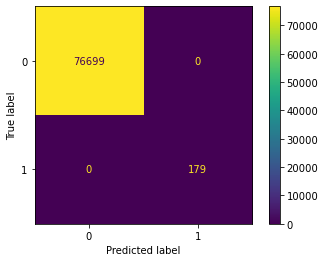

In [34]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(lgbm, test_data_to_model, Y_pred)
plt.show()

One has to use df format for the confusion matrix

In [35]:
from sklearn.metrics import roc_curve

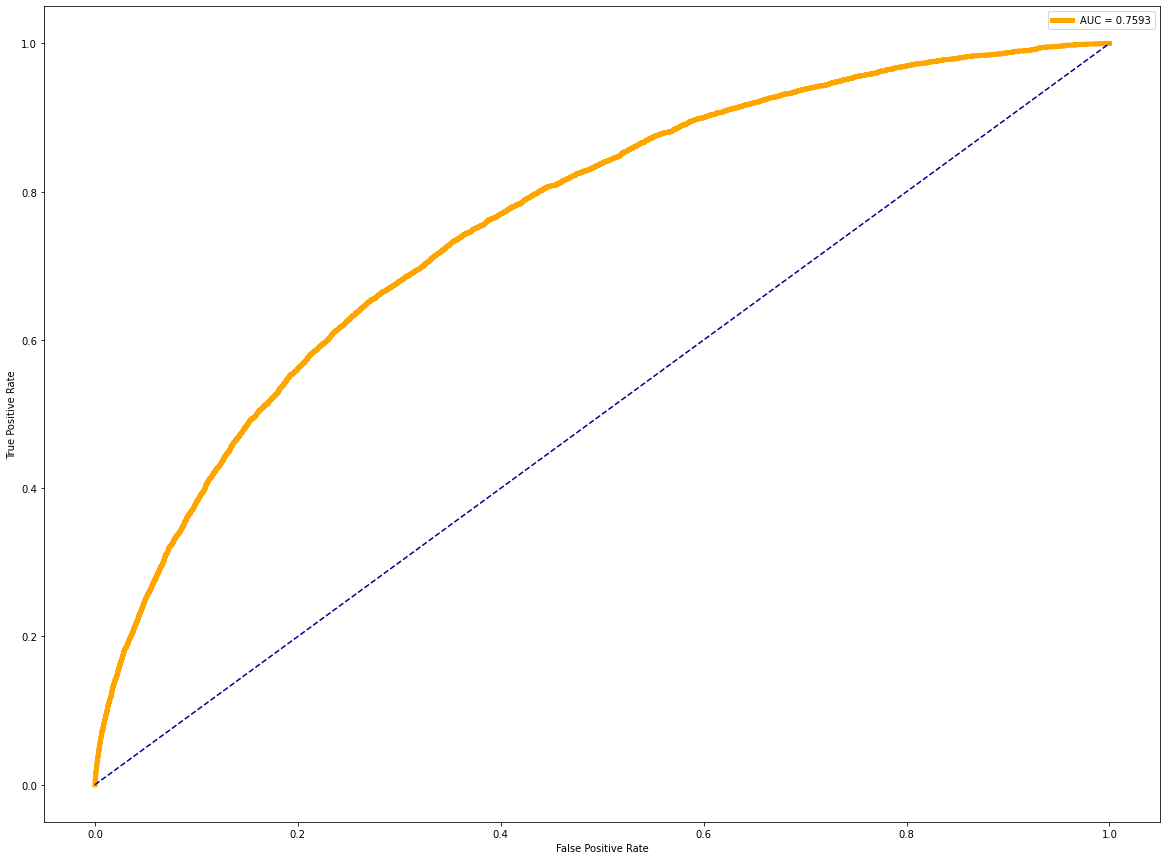

In [36]:
fig = plt.figure(figsize=(20,15))
fpr,tpr,_ = roc_curve(test_Target, Y_pred_proba[:, 1])
plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

The area under the curve shows the ability of the model to correctly predict TP and TN.

We want true positive rate to be 1 to minimize the possible loss of the bank.


### Préparation des fichiers pour l'API

In [32]:
### Create a Pickle file using serialization 
import pickle
pickle_out = open("lgbm.pkl","wb")
pickle.dump(lgbm, pickle_out)
pickle_out.close()

### Feature Importance

Text(0.5, 0, 'Feature Importance')

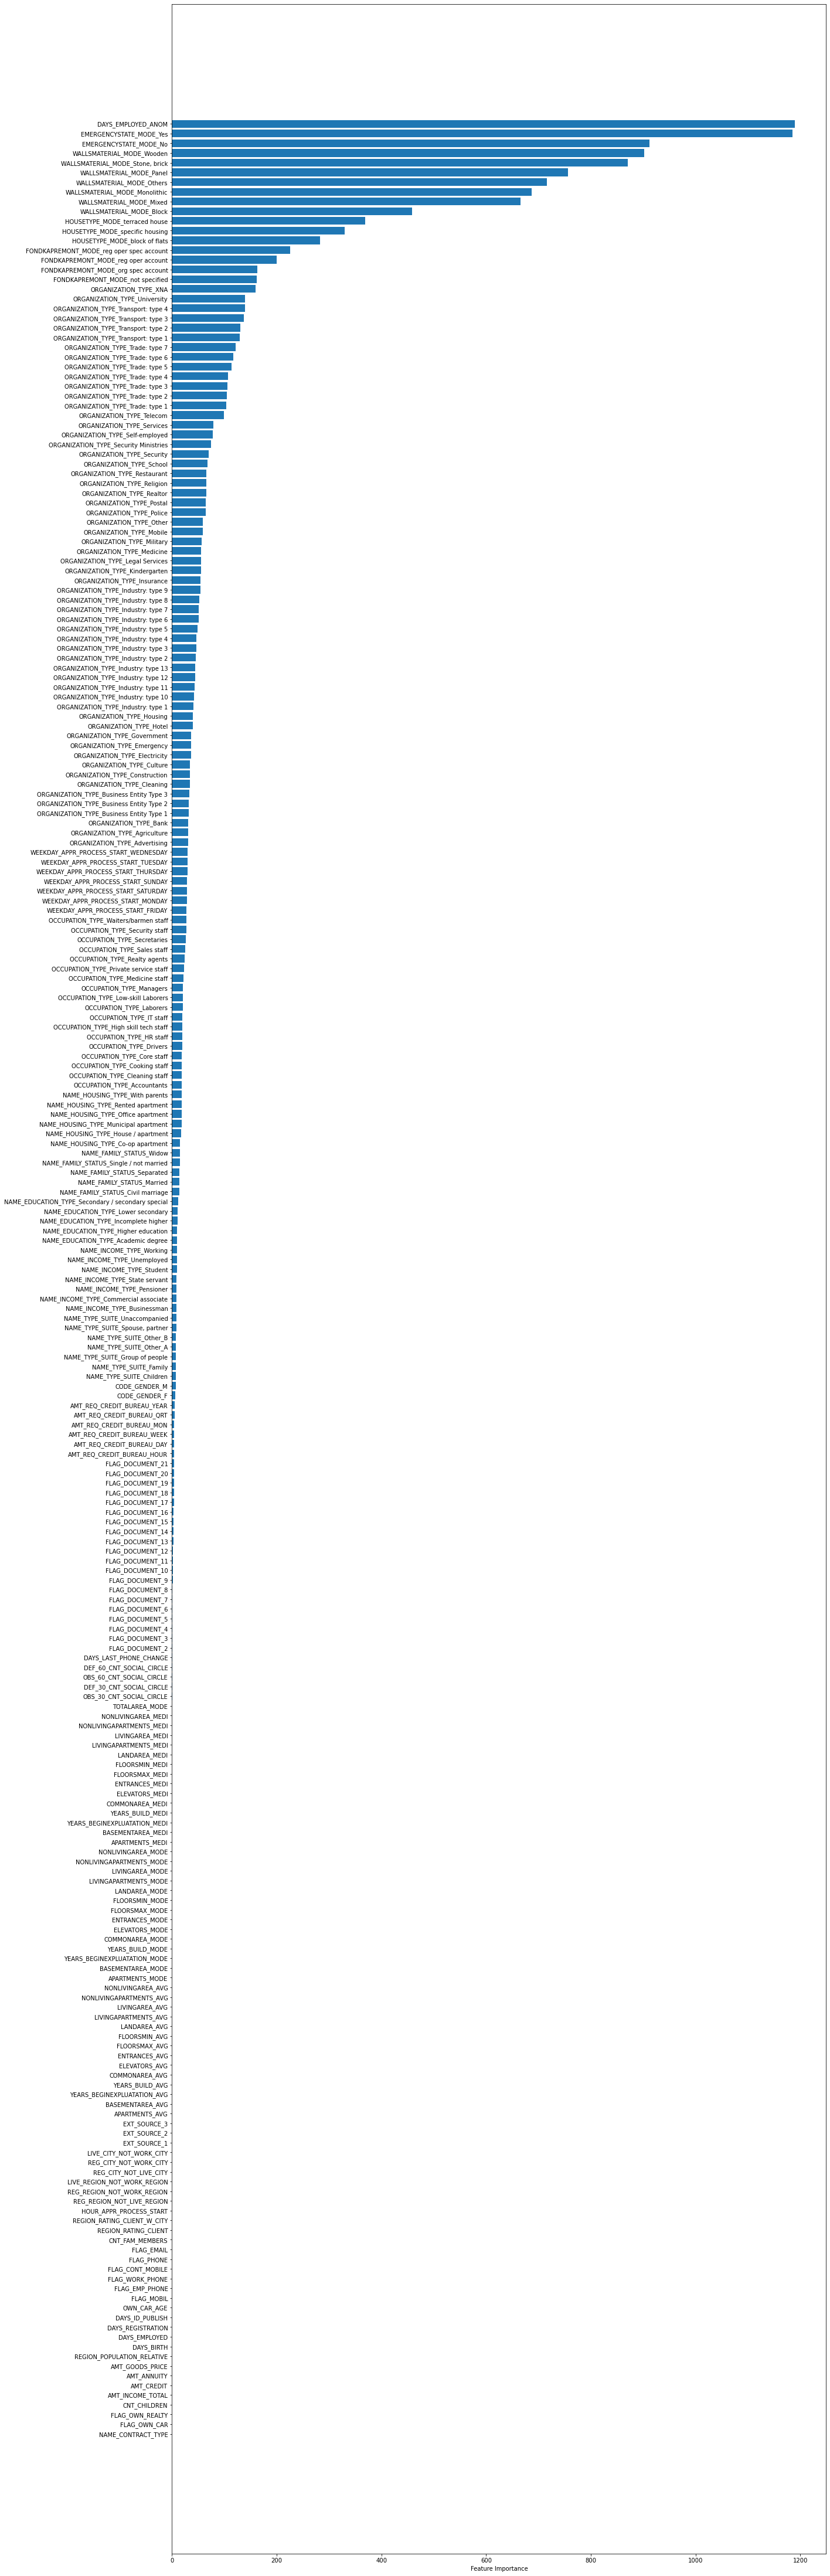

In [66]:
fig = plt.figure(figsize=(20,80))
sort = lgbm.feature_importances_.argsort()
plt.barh(data_to_model_list, lgbm.feature_importances_[sort])
plt.xlabel("Feature Importance")

**Shap**

In [46]:
import shap

In [68]:
# DF, based on which importance is checked
X_importance = test_data_to_model

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_importance)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


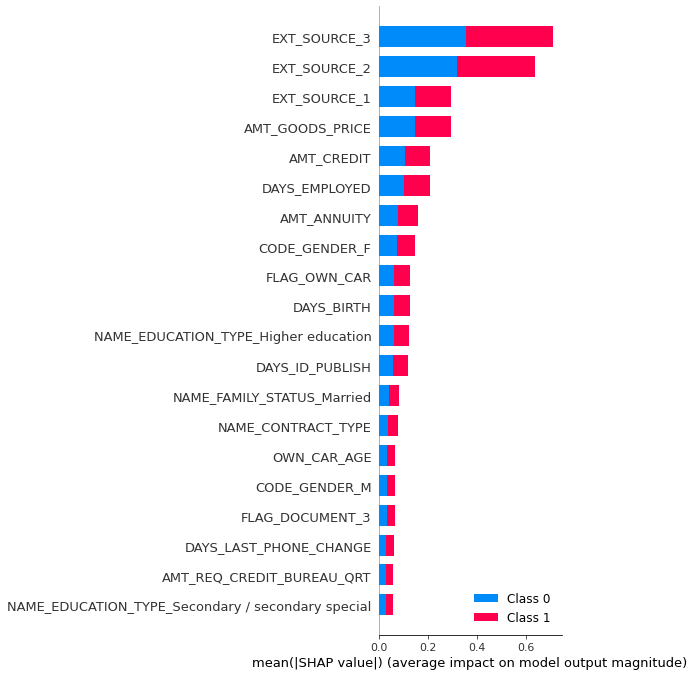

In [69]:
# Plot summary_plot
shap.summary_plot(shap_values, X_importance, feature_names = data_to_model_list)